<a href="https://colab.research.google.com/github/ZHONGCHUYUN/Deep_learning_cw/blob/master/460cw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework2: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

A PDF version of this notebook is also provided in case the figures do not render correctly.

**The deadline for submission is 19:00, Thu 14th February, 2019**

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](https://github.com/ZHONGCHUYUN/Deep_learning_cw/blob/master/utils/resnet-block.png?raw=1)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](https://github.com/ZHONGCHUYUN/Deep_learning_cw/blob/master/utils/resnet.png?raw=1)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution and max pooling operation. 


### YOUR TASK

- implement the forward pass for Conv2D and MaxPool2D
- You can only fill in the parts which are specified as "YOUR CODE HERE"
- You are **NOT** allowed to use the torch.nn module and the conv2d/maxpooling functions in torch.nn.functional

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Conv2D(nn.Module):
    
    def __init__(self, inchannel, outchannel, kernel_size, stride, padding, bias = True):
        
        super(Conv2D, self).__init__()
        
        self.inchannel = inchannel
        self.outchannel = outchannel
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        self.weights = nn.Parameter(torch.Tensor(outchannel, inchannel, 
                                                 kernel_size, kernel_size))
        self.weights.data.normal_(-0.1, 0.1)
        
        if bias:
            self.bias = nn.Parameter(torch.Tensor(outchannel, ))
            self.bias.data.normal_(-0.1, 0.1)
        else:
            self.bias = None
            
        
    def forward(self, x):
        
        ##############################################################
        #                       YOUR CODE HERE                       #       
        ##############################################################
        batch_size = x.shape[0]
        input_width = x.shape[2]
        input_length = x.shape[3]

        output_width = (input_width+2*self.padding-self.kernel_size)//self.stride+1
        output_length = (input_length+2*self.padding-self.kernel_size)//self.stride+1
        
        input_unf = torch.nn.functional.unfold(x, kernel_size=self.kernel_size, padding = self.padding, stride = self.stride)
        if self.bias:
          output_unf = input_unf.transpose(1,2).matmul(self.weights.view(self.weights.size(0),-1).t()).transpose(1,2)+self.bias.view(-1,1)
        else:
          output_unf = (input_unf.transpose(1,2).matmul(self.weights.view(self.weights.size(0),-1).t()).transpose(1,2))
        
        
        output = output_unf.view(batch_size, self.outchannel, output_width, output_length)
        
        

        ##############################################################
        #                       END OF YOUR CODE                     #
        ##############################################################
        

        return output


In [0]:
class MaxPool2D(nn.Module):
    
    def __init__(self, pooling_size):
        # assume pooling_size = kernel_size = stride
        
        super(MaxPool2D, self).__init__()
        
        self.pooling_size = pooling_size
        

    def forward(self, x):
        
        
        ##############################################################
        #                       YOUR CODE HERE                       #       
        ##############################################################
#brute force#
#         batch_size = x.shape[0]
#         channel_size = x.shape[1]
#         input_width = x.shape[2]
#         input_length = x.shape[3]
#         output_width = input_width//self.pooling_size
#         output_length = input_length//self.pooling_size
        
#         output = torch.Tensor(batch_size, channel_size, output_width, output_length)
        
#         for b in range(batch_size):
#           for c in range(channel_size):
#             for w in range(output_width):
#               for l in range(output_length):
#                 output[b][c][w][l] = torch.max(x[b][c][(w*self.pooling_size):((w+1)*self.pooling_size),(l*self.pooling_size):((l+1)*self.pooling_size)]).item()
       
        x_unf = x.unfold(2,self.pooling_size, self.pooling_size).unfold(3,self.pooling_size, self.pooling_size)
        output = x_unf.contiguous().view(x_unf.size()[:4]+(-1,)).max(dim=-1)[0]
        
        ##############################################################
        #                       END OF YOUR CODE                     #
        ##############################################################
        
        return output
        

    

In [0]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2D(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2D(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2D(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


In [0]:
# define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2D(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2D(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

## Part 2 (40 points)

In this part, you will train the ResNet-18 defined in the previous part on the CIFAR-10 dataset. Code for loading the dataset, training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimiser

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

**YOUR ANSWER FOR 2.4 HERE**

I think Bayesian optimization is the best algorithm compared to grid search and random search. Because using Bayesian Optimization can help to speed up the process by reducing the computation task.
A:

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T


transform = T.ToTensor()


# load data

NUM_TRAIN = 49000
print_every = 100


data_dir = './data'
cifar10_train = dset.CIFAR10(data_dir, train=True, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10(data_dir, train=True, download=True, transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)


USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return 100*acc


def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                #check_accuracy(loader_val, model)
                print()

In [16]:
!pip install GPy

In [17]:
!pip install GPyOpt

In [30]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
import GPy
import GPyOpt
from numpy.random import seed
import matplotlib
######using random search######
# from hyperopt import hp
# from hyperopt import fmin
# from hyperopt import Trials
# from hyperopt import tpe
# from hyperopt import STATUS_OK

# MAX_EVALS = 20

# def objective(params):
#   model = ResNet18()
  
#   optimizer = optim.Adam(model.parameters(), lr = params['learning_rate'], betas = (params['beta0'], params['beta1']), eps = params['eps'], weight_decay = params['weight_decay'])
  
#   train_part(model, optimizer, epochs = 10)
  
#   loss = 1 - check_accuracy(loader_test, model)

#   return {'loss': loss, 'params': params, 'status': STATUS_OK}

# # Learning rate log uniform distribution

                                                
# space = {
#     'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)),
#     'beta0': hp.uniform('beta0', 0.1, 0.999),
#     'beta1': hp.uniform('beta1', 0.1, 0.999),
#     'eps': hp.uniform('eps', 1e-8, 1e-5),
#     'weight_decay':hp.uniform('weight_decay',0,0.5)
# }
 
# bayes_trials = Trials()               
                                                    
# best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)



def objective(bounds):
  bounds = bounds.squeeze()
  model = ResNet18()
  optimizer = optim.Adam(model.parameters(), lr = bounds[0], betas = (bounds[1],bounds[2]), eps = bounds[3], weight_decay = bounds[4])
  train_part(model,optimizer, epochs = 10)
  loss = 1-check_accuracy(loader_test, model)
  return {'loss':loss}
  
bounds = [{'name':'learning_rate','type':'continuous','domain':(0.001,0.1)},
         {'name':'beta0','type':'continuous','domain':(0.1,0.999)},
         {'name':'beta1','type':'continuous','domain':(0.1,0.999)},
         {'name':'eps','type':'continuous','domain':(1e-8,1e-5)},
         {'name':'weight_decay','type':'continuous','domain':(0,0.5)}]

seed(123)
myBopt = GPyOpt.methods.BayesianOptimization(f=objective,domain = bounds, model_type = 'GP', acquisition_type='EI', exact_feval=True)
max_iter = 15
max_time = 60
eps = 10e-6
myBopt.run_optimization(max_iter, max_time, eps)
myBopt.plot_acquisition()
myBopt.plot_convergence()
##############################################################
#                       END OF YOUR CODE                     #
##############################################################

print(best)
# # define and train the network
# model = ResNet18()
# optimizer = optim.Adam(model.parameters())

# #report test set accuracy

# check_accuracy(loader_test, model)


# # save the model
# torch.save(model.state_dict(), 'model.pt')

766
Epoch: 0, Iteration 0, loss = 2.4451

Epoch: 0, Iteration 100, loss = 2.2972

Epoch: 0, Iteration 200, loss = 2.3776

Epoch: 0, Iteration 300, loss = 2.3644

Epoch: 0, Iteration 400, loss = 2.3257

Epoch: 0, Iteration 500, loss = 2.4086

Epoch: 0, Iteration 600, loss = 2.3551

Epoch: 0, Iteration 700, loss = 2.3105

766
Epoch: 1, Iteration 0, loss = 2.3585

Epoch: 1, Iteration 100, loss = 2.2940

Epoch: 1, Iteration 200, loss = 2.3493

Epoch: 1, Iteration 300, loss = 2.3109

Epoch: 1, Iteration 400, loss = 2.4019

Epoch: 1, Iteration 500, loss = 2.4002

Epoch: 1, Iteration 600, loss = 2.4223

Epoch: 1, Iteration 700, loss = 2.3675

766
Epoch: 2, Iteration 0, loss = 2.3696

Epoch: 2, Iteration 100, loss = 2.3360

Epoch: 2, Iteration 200, loss = 2.6003

Epoch: 2, Iteration 300, loss = 2.3578

Epoch: 2, Iteration 400, loss = 2.4509

Epoch: 2, Iteration 500, loss = 2.4738

Epoch: 2, Iteration 600, loss = 2.2967

Epoch: 2, Iteration 700, loss = 2.2610

766
Epoch: 3, Iteration 0, loss = 

KeyboardInterrupt: ignored

In [0]:
## Part 3 (20 points)


The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**

A:

<Figure size 576x396 with 0 Axes>

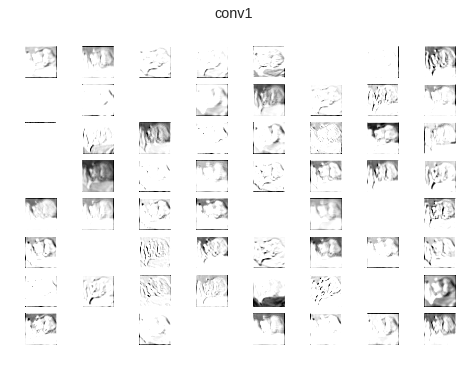

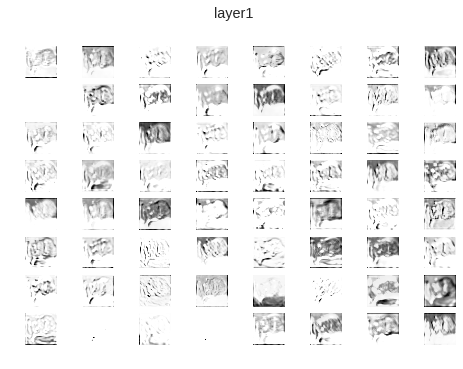

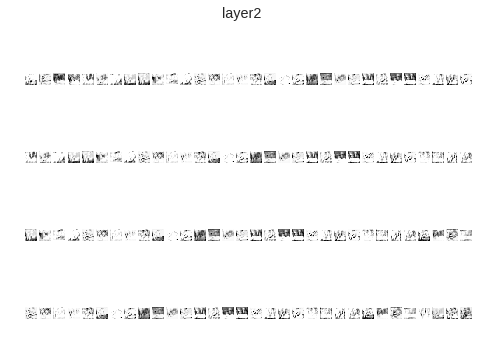

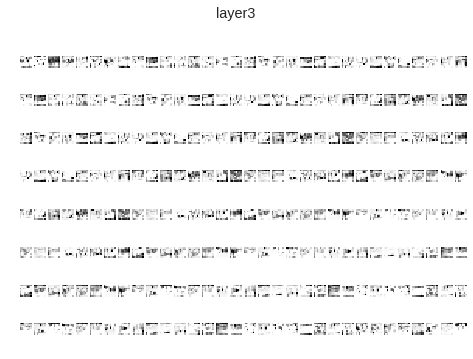

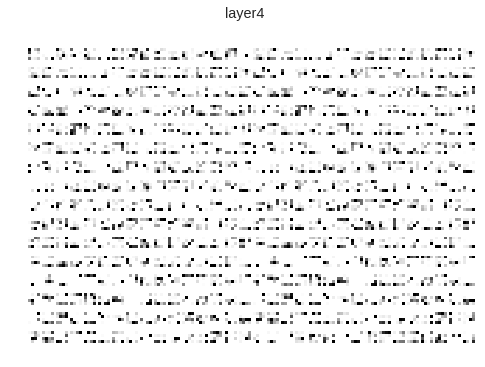

In [0]:
!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')

**=============== END OF CW2 ===============**